## Geopandas and a Map of the Middle World:

On the way to wondering how to create a map of the middle kingdom for Islamic history I also got thinking about creating a personalized Barcelona map. Turns out there are compete geojson files for Barca which are in the included folder.

This [website](https://docs.astraea.earth/hc/en-us/articles/360043919911-Read-a-GeoJSON-File-into-a-GeoPandas-DataFrame) offers some guidance for reading such files into a geopandas data frame. Let's see if it works.

[Hurricane Tracks:](https://blog.matthewgove.com/2021/06/11/python-geopandas-easily-create-stunning-maps-without-a-gis-program/) This might be helpful in layering patches for the extent of the middle world.

[Cora's Islamic History Maps](http://web.cocc.edu/cagatucci/classes/hum213/Maps/Maps3HistoryMiddle.htm) For now Cora's HUM213 course materials are still up on the web. They provide some good guidelines for what I'm working to reproduce with geopandas.

[Geopandas Reference:](https://geopandas.org/en/stable/index.html)

In [1]:
import geopandas as gpd
import geoplot as gp
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from IPython.display import display, Image
from shapely.geometry import Point

### Global Geopandas Data Sources

The datasets given below are broadly available for general use. Seems potentially useful for drawing low res maps of the world.

In [2]:
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

### Barcelona Geojson Data Sets

The bcn-geodata contains a multitude of geographic data sets in geojson format. The 2020 data was imported from [this github](https://github.com/martgnz/bcn-geodata). 

A range of other data is available on the [Barcelona municipal open data site](https://opendata-ajuntament.barcelona.cat/en/) which seems like an AWESOME resource. This is the [mapping article](https://diegoquintanav.github.io/folium-barcelona-EN.html) that got me turned on to the data. Need to explore more for sure.

Next two cells read some data in from the database and then print out the .crs (coordinate reference systems) for the dataframe and the type of dataframe to be sure everything is on track.

#### Adding Cities:

The basic database has only capitals and a few added cities. For projects we are likely to want to add some cities. This is the format for adding a city after looking up it's long/lat location. Be cautious -- I initially swapped lat and long and got some frustrating results. Also need to impose the original 'WGS 84' reference system on the data frame or the next conversion is unhappy.

[Geopandas Projection Info:](https://geopandas.org/en/stable/docs/user_guide/projections.html) There were some issues with the projections at various points in the analysis so itn was suggested to project the data into a Mercator projection as per the linked documentation. The Mercator projection doesn't use lat/long so the geometry values are much larger for determining offsets. Actual units are meters!! Any lat/long information will need to be projected to [EPSG:3395](https://epsg.io/3395) for consistency.


In [3]:
# Find path to default database and read
path_to_earth = gpd.datasets.get_path("naturalearth_lowres")
path_to_cities = gpd.datasets.get_path("naturalearth_cities")

earthDF = gpd.read_file(path_to_earth)
citiesDF = gpd.read_file(path_to_cities)

# add cities in lat/long format before conversion
meccaLoc = Point(39.826168, 21.422510)
medinaLoc = Point(39.612236, 24.470901)
cordobaLoc = Point(-4.779651, 37.888075)
barcaLoc = Point(2.173695, 41.385155)
stCompostelaLoc = Point(-8.544844, 42.878212)
zaragozaLoc = Point(-0.887712, 41.649693)
citiesDF.loc[len(citiesDF.index)] = ['Mecca', meccaLoc]
citiesDF.loc[len(citiesDF.index)] = ['Medina', medinaLoc]
citiesDF.loc[len(citiesDF.index)] = ['Cordoba', cordobaLoc]
citiesDF.loc[len(citiesDF.index)] = ['Barcelona', barcaLoc]
citiesDF.loc[len(citiesDF.index)] = ['Santiago de Compostela', stCompostelaLoc]
citiesDF.loc[len(citiesDF.index)] = ['Zaragoza', zaragozaLoc]

In [4]:
citiesDF.crs = 'WGS 84'

In [5]:
# remove antarctica and reproject to Mercator
earthDF = earthDF[(earthDF.name != "Antarctica") & (earthDF.name != "Fr. S. Antarctic Lands")]
earthDF = earthDF.to_crs("EPSG:3395")
citiesDF = citiesDF.to_crs("EPSG:3395")

# create extra columns of needed info
# centroid is a method so centroid data is not in data base

earthDF['centroid_col'] = earthDF.centroid

# Need a label location for cities that can
# be manipulated relative to location for city.
# Some places I need to move label relative to city
citiesDF['label_location'] = citiesDF['geometry']

### Fixing City Locations before .sjoin

Joining the city and country files looks for cities within the boundaries of the geometry of the countries. Investigation (GeoMWorkCheck.ipynb) has shown that some of the cities are actually outside of their countries (usuallly in bodies of water). Each needs to be researched (GeoMWorkCheck.ipynb) and fixed. Each cell contains an individual fix for clarity. They are...

* Tripoli - down 6000 m
* Jerusalem - left 2000 m, down 4000 m
* Muscat (Oman) - down 2000 m

In [6]:
# Where is Tripoli?
#print("Current Location: ", citiesDF[citiesDF['name']=='Tripoli'])
citiesDF.at[ 153 , 'geometry']= Point(citiesDF.at[ 153 , 'geometry'].x, citiesDF.at[ 153 , 'geometry'].y - 6000.)
#print("New Location: ", citiesDF[citiesDF['name']=='Tripoli'])

# Where is Jerusalem?
#print("Jerusalem Current: " , citiesDF[citiesDF['name']=='Jerusalem'])
citiesDF.at[ 129 , 'geometry']= Point(citiesDF.at[ 129 , 'geometry'].x - 2000., citiesDF.at[ 129 , 'geometry'].y - 4000.)
#print("Jerusalem New: " , citiesDF[citiesDF['name']=='Jerusalem'])

# Where is Muscat
#print("Muscat Current: " , citiesDF[citiesDF['name']=='Muscat'])
citiesDF.at[ 66 , 'geometry']= Point(citiesDF.at[ 66 , 'geometry'].x, citiesDF.at[ 66 , 'geometry'].y - 2000)
#print("Muscat New: " , citiesDF[citiesDF['name']=='Muscat'])

In [7]:
citiesDF[citiesDF['name'] == 'Riyadh']

,name,geometry,label_location
188,Riyadh,POINT (5206501.172 2814121.335),POINT (5206501.172 2814121.335)


In [8]:
citiesDF[citiesDF['name'] == 'Mecca']

,name,geometry,label_location
202,Mecca,POINT (4433428.742 2426730.637),POINT (4433428.742 2426730.637)


In [9]:
# join cities with countries in intersection database
# only has cities points but also has country column
earthCitiesDF = gpd.sjoin(citiesDF, earthDF)
#earthCitiesDF = earthCitiesDF.to_crs("EPSG:3395")

In [10]:
earthCitiesDF

,name_left,geometry,label_location,index_right,pop_est,continent,name_right,iso_a3,gdp_md_est,centroid_col
0,Vatican City,POINT (1386304.649 5117957.424),POINT (1386304.649 5117957.424),141,62137802,Europe,Italy,ITA,2221000.0,POINT (1344468.493 5270796.742)
1,San Marino,POINT (1385011.519 5425900.277),POINT (1385011.519 5425900.277),141,62137802,Europe,Italy,ITA,2221000.0,POINT (1344468.493 5270796.742)
192,Rome,POINT (1389413.359 5117155.672),POINT (1389413.359 5117155.672),141,62137802,Europe,Italy,ITA,2221000.0,POINT (1344468.493 5270796.742)
2,Vaduz,POINT (1059390.800 5932596.001),POINT (1059390.800 5932596.001),114,8754413,Europe,Austria,AUT,416600.0,POINT (1567819.765 6013069.190)
184,Vienna,POINT (1821709.303 6108649.352),POINT (1821709.303 6108649.352),114,8754413,Europe,Austria,AUT,416600.0,POINT (1567819.765 6013069.190)
...,...,...,...,...,...,...,...,...,...,...
195,Jakarta,POINT (11891981.986 -683858.330),POINT (11891981.986 -683858.330),8,260580739,Asia,Indonesia,IDN,3028000.0,POINT (13072451.147 -247101.543)
196,Bogota,POINT (-8247136.737 509015.407),POINT (-8247136.737 509015.407),32,47698524,South America,Colombia,COL,688000.0,POINT (-8135225.527 436973.588)
197,Cairo,POINT (3478513.938 3488829.344),POINT (3478513.938 3488829.344),163,97041072,Africa,Egypt,EGY,1105000.0,POINT (3321337.184 3055338.636)
198,Tokyo,POINT (15556838.901 4232706.081),POINT (15556838.901 4232706.081),155,126451398,Asia,Japan,JPN,4932000.0,POINT (15389725.053 4548738.743)


### ..and then there's plotting!

So much to figure out here and comment. Much learning happening - yikes!

To control the density of the facecolor differently than the density of the edgecolor a stackexchange thread suggested using colorConverter to define a face color WITH the alpha already packaged in. Note that I needed to import the colorConverter library to do this.

Realized that the plot is built up in layers so the order in which I display the layers affects which color is laid on top of the other. Thoughtful choices seem important here.

**Questions:** 

* How do I identify the names of the specific regions. The names don't appear to be in the dataframe -- opening up the geojson file indicated that there 


In [11]:
# continents to help sort through naming conventions

#europe = earthDF[earthDF['continent'] == "Europe"]
#asia = earthDF[earthDF['continent'] == "Asia"]

# countries of interest

# Southern Europe
portugal = earthDF[earthDF.name == 'Portugal']
spain = earthDF[earthDF.name == 'Spain']
france = earthDF[earthDF.name == 'France']
italy = earthDF[earthDF.name == 'Italy']
greece = earthDF[earthDF.name == 'Greece']
slovenia = earthDF[earthDF.name == 'Slovenia']
croatia = earthDF[earthDF.name == 'Croatia']
bosnia = earthDF[earthDF.name == 'Bosnia and Herz.']
montenegro = earthDF[earthDF.name == 'Montenegro']
albania = earthDF[earthDF.name == 'Albania']
austria = earthDF[earthDF.name == 'Austria']
serbia = earthDF[earthDF.name == 'Serbia']
macedonia = earthDF[earthDF.name == 'Macedonia']
kosovo = earthDF[earthDF.name == 'Kosovo']
bulgaria = earthDF[earthDF.name == 'Bulgaria']
balkans = croatia.append(bosnia).append(montenegro).append(albania).append(serbia).append(kosovo).append(macedonia)

# France is an multipolygon country. This set of steps breaks up and retains
# only those parts I want.
exploded = france.explode()
exploded.reset_index(drop = True, inplace= True)
exploded.drop(0, inplace = True)
france = exploded
france['centroid_col'] = exploded.centroid
france

# North Africa
libya = earthDF[earthDF.name == 'Libya']
egypt = earthDF[earthDF.name == 'Egypt']
algeria = earthDF[earthDF.name == 'Algeria']
tunisia = earthDF[earthDF.name == 'Tunisia']
morocco = earthDF[earthDF.name == 'Morocco']

# eastern middle world
india = earthDF[earthDF.name == 'India']
pakistan = earthDF[earthDF.name == 'Pakistan']
afghanistan = earthDF[earthDF.name == 'Afghanistan']
iran = earthDF[earthDF.name == 'Iran']
iraq = earthDF[earthDF.name == 'Iraq']

# Arabian Peninsula
saudiArabia = earthDF[earthDF.name == 'Saudi Arabia']
yemen = earthDF[earthDF.name == 'Yemen']
oman = earthDF[earthDF.name == 'Oman']
kuwait = earthDF[earthDF.name == 'Kuwait']
uae = earthDF[earthDF.name == 'United Arab Emirates']

# the Levant
israel = earthDF[earthDF.name == 'Israel']
lebanon = earthDF[earthDF.name == 'Lebanon']
syria = earthDF[earthDF.name == 'Syria']
jordan = earthDF[earthDF.name == 'Jordan']

# append to form regions
northAfrica = libya.append(algeria).append(egypt).append(tunisia).append(morocco)
southEurope = portugal.append(spain).append(france).append(italy).append(greece).append(slovenia)
southEurope = southEurope.append(balkans).append(austria).append(serbia).append(slovenia).append(bulgaria)
persiaIndia = india.append(pakistan).append(iraq).append(iran).append(afghanistan)
arabia = saudiArabia.append(kuwait).append(oman).append(uae).append(yemen)
levant = israel.append(lebanon).append(jordan).append(syria)

# tidy up indices which are from original file
northAfrica.reset_index(drop = True, inplace= True)
southEurope.reset_index(drop = True, inplace= True)
persiaIndia.reset_index(drop = True, inplace= True)
arabia.reset_index(drop = True, inplace= True)
levant.reset_index(drop = True, inplace= True)


### Sorting out the Cities:

The joined data base in the orginal generation of the data frames has both cities and countries in the frame. Because some countries have more than one cities listed I can sort through the list of countries and pull out the cities that match. Still going to keep them separate for each portion of the map to assist with plotting choices.

In [12]:
citiesNA = gpd.GeoDataFrame()
citiesSE = gpd.GeoDataFrame()
citiesMWE = gpd.GeoDataFrame()
citiesAP = gpd.GeoDataFrame()
citiesLV = gpd.GeoDataFrame()

for name in enumerate(northAfrica.name):
    citiesNA = citiesNA.append(earthCitiesDF[earthCitiesDF['name_right'] == name[1]])

for name in enumerate(southEurope.name):
    citiesSE = citiesSE.append(earthCitiesDF[earthCitiesDF['name_right'] == name[1]])

for name in enumerate(persiaIndia.name):
    citiesMWE = citiesMWE.append(earthCitiesDF[earthCitiesDF['name_right'] == name[1]])

for name in enumerate(arabia.name):
    citiesAP = citiesAP.append(earthCitiesDF[earthCitiesDF['name_right'] == name[1]])

for name in enumerate(levant.name):
    citiesLV = citiesLV.append(earthCitiesDF[earthCitiesDF['name_right'] == name[1]])

citiesNA.reset_index(drop = True, inplace= True)
citiesSE.reset_index(drop = True, inplace= True)
citiesMWE.reset_index(drop = True, inplace= True)
citiesAP.reset_index(drop = True, inplace= True)
citiesLV.reset_index(drop = True, inplace= True)

### Name and City for a single country

Typically I pull the name from the name column and the centroid is the 'center of mass' of the polygon that represents the country

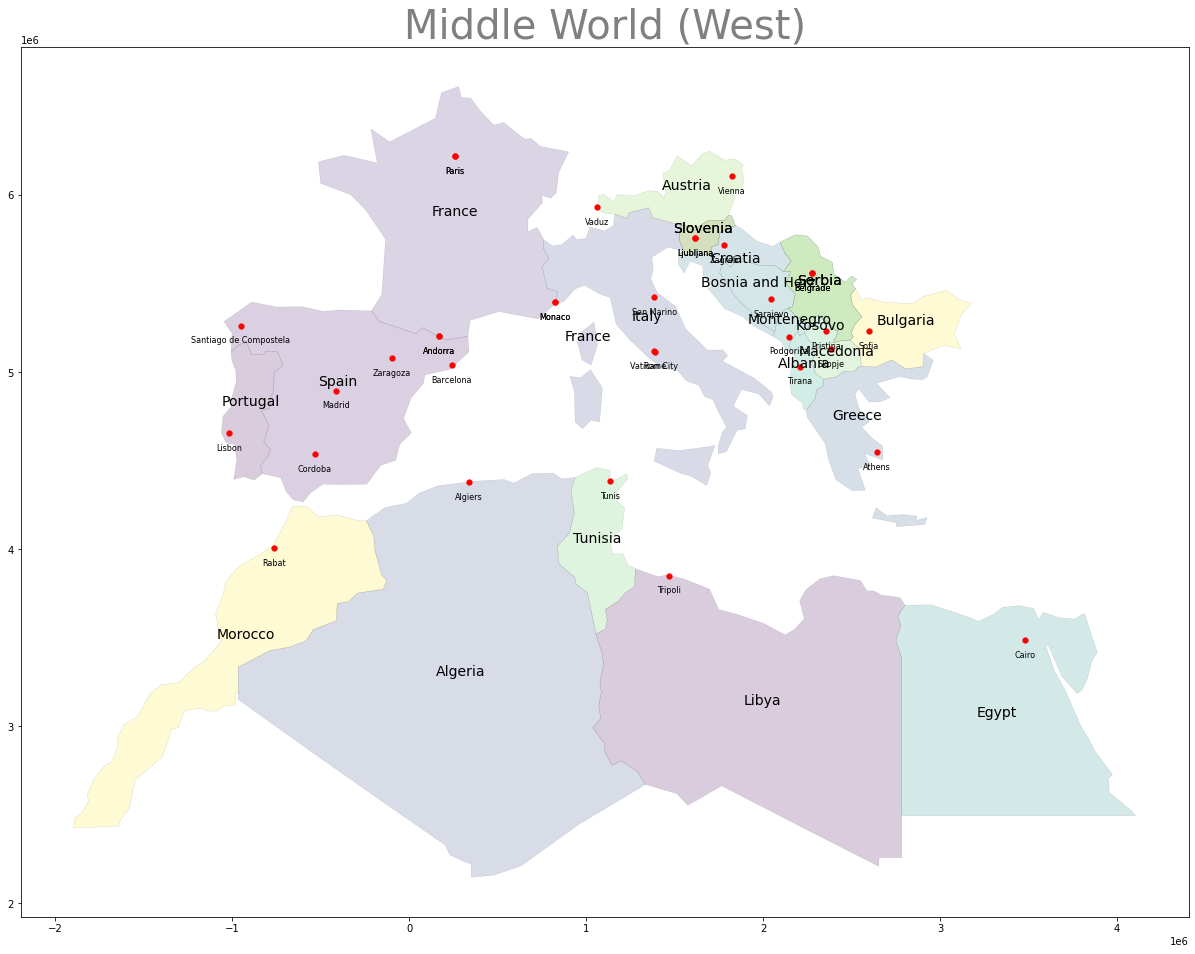

In [13]:
fig, ax = plt.subplots(figsize=(24,16))

plotLabelOffset = 100000.

fc1 = colorConverter.to_rgba('green', alpha=0.2)

northAfrica.plot(ax=ax, cmap = 'viridis',edgecolor='k', linewidth=0.3, alpha = 0.2) 
southEurope.plot(ax=ax, cmap = 'viridis',edgecolor='k', linewidth=0.3, alpha = 0.2) 

citiesNA.plot(ax=ax, facecolor = 'r',edgecolor='r', linewidth=0.2)
citiesSE.plot(ax=ax, facecolor = 'r',edgecolor='r', linewidth=0.2)

for count,name in enumerate(northAfrica.name):
    ax.annotate(text = name, xy = (northAfrica.centroid_col.x[count], northAfrica.centroid_col.y[count]), ha='center', fontsize=14)

for countC,nameC in enumerate(citiesNA.name_left):
    ax.annotate(text = nameC, xy = (citiesNA.geometry.x[countC], citiesNA.geometry.y[countC] - plotLabelOffset), ha='center', fontsize=8)
    
for count,name in enumerate(southEurope.name):
    ax.annotate(text = name, xy = (southEurope.centroid_col.x[count], southEurope.centroid_col.y[count] + plotLabelOffset/5.), ha='center', fontsize=14)

for countC,nameC in enumerate(citiesSE.name_left):
    ax.annotate(text = nameC, xy = (citiesSE.geometry.x[countC], citiesSE.geometry.y[countC] - plotLabelOffset), ha='center', fontsize=8)

plt.title("Middle World (West)", fontsize=40, color='grey')
#plt.xlim(2.125, 2.150)
#plt.ylim(41.375, 41.400)
#plt.axis('equal')

plt.show()

### Eastern Half of Middle World

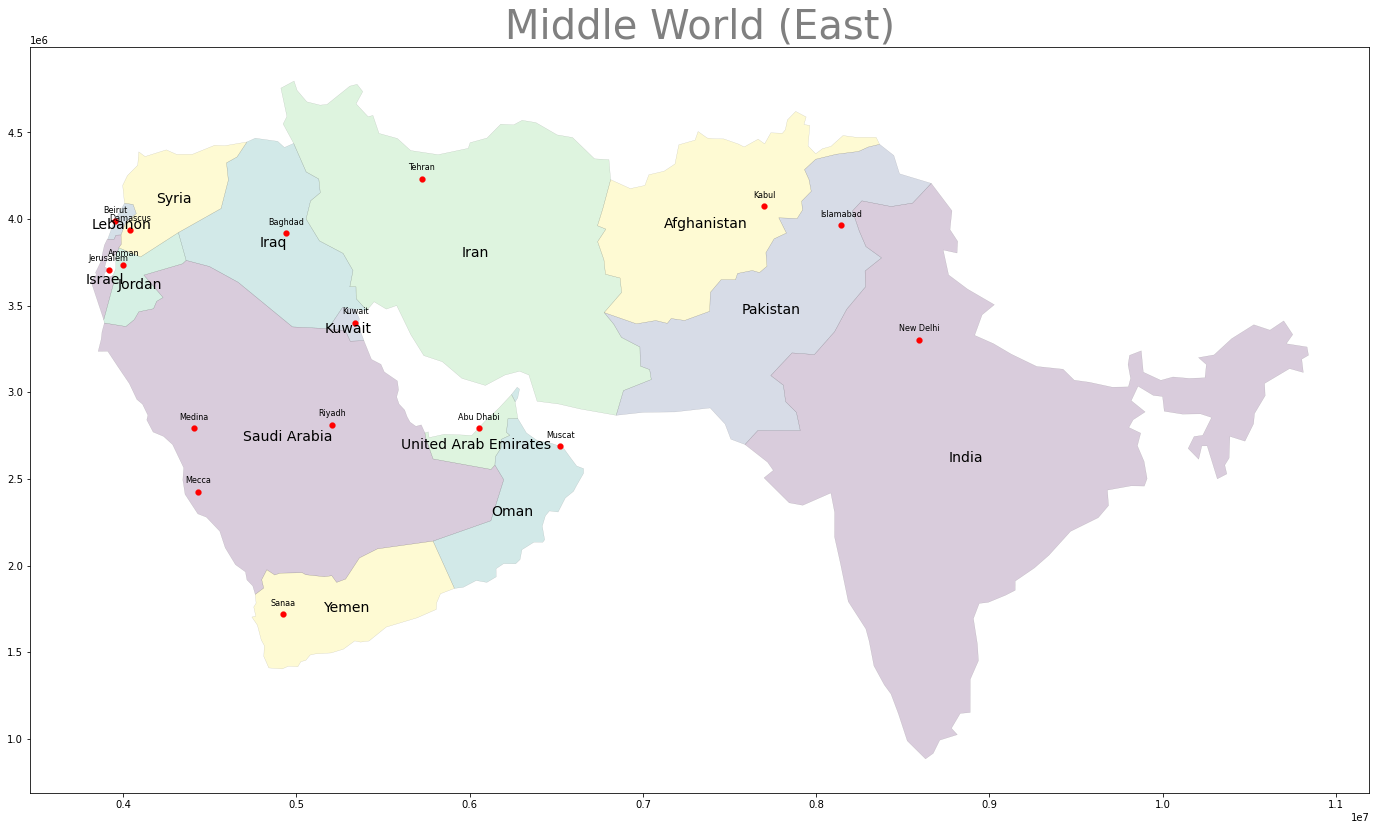

In [131]:
fig2, ax2 = plt.subplots(figsize=(24,16))

plotLabelOffsetB = 50000.
fc1 = colorConverter.to_rgba('green', alpha=0.2)

persiaIndia.plot(ax=ax2, cmap = 'viridis',edgecolor='k', linewidth=0.3, alpha = 0.2) 
arabia.plot(ax=ax2, cmap = 'viridis',edgecolor='k', linewidth=0.3, alpha = 0.2) 
levant.plot(ax=ax2, cmap = 'viridis',edgecolor='k', linewidth=0.3, alpha = 0.2) 

citiesMWE.plot(ax=ax2, facecolor = 'r',edgecolor='r', linewidth=0.2)
citiesAP.plot(ax=ax2, facecolor = 'r',edgecolor='r', linewidth=0.2)
citiesLV.plot(ax=ax2, facecolor = 'r',edgecolor='r', linewidth=0.2)

for count,name in enumerate(persiaIndia.name):
    ax2.annotate(text = name, xy = (persiaIndia.centroid_col.x[count], persiaIndia.centroid_col.y[count]-plotLabelOffsetB), ha='center', fontsize=14)
for count,name in enumerate(arabia.name):
    ax2.annotate(text = name, xy = (arabia.centroid_col.x[count], arabia.centroid_col.y[count] - plotLabelOffsetB), ha='center', fontsize=14)
for count,name in enumerate(levant.name):
    ax2.annotate(text = name, xy = (levant.centroid_col.x[count], levant.centroid_col.y[count] - plotLabelOffsetB), ha='center', fontsize=14)
    
for countC,nameC in enumerate(citiesMWE.name_left):
    ax2.annotate(text = nameC, xy = (citiesMWE.geometry.x[countC], citiesMWE.geometry.y[countC]+plotLabelOffsetB), ha='center', fontsize=8)
for countC,nameC in enumerate(citiesAP.name_left):
    ax2.annotate(text = nameC, xy = (citiesAP.geometry.x[countC], citiesAP.geometry.y[countC]+plotLabelOffsetB), ha='center', fontsize=8)
for countC,nameC in enumerate(citiesLV.name_left):
    ax2.annotate(text = nameC, xy = (citiesLV.geometry.x[countC], citiesLV.geometry.y[countC]+plotLabelOffsetB), ha='center', fontsize=8)    

plt.title("Middle World (East)", fontsize=40, color='grey')
#plt.xlim(2.125, 2.150)
#plt.ylim(41.375, 41.400)
#plt.axis('equal')

plt.show()